# M2 SIF - SED
## Lab session : Differential privacy and the Laplace Mechanism -- CORRECTION

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns

## Loading data

In [18]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
         'marital-status', 'occupation', 'relationship', 'race',
         'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
         'native-country', 'income']

adult = pd.read_csv(url, sep=',\s+', header=None, names=names, na_values='?', engine='python', skipinitialspace=True)

adult.dropna(inplace=True)

adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Performing the queries needed

### Query C: number of non-white people

In [19]:
sum(adult['race'] != 'White')

4229

### Query A: average age of people with income over 50K

In [20]:
adult[adult['income'] == '>50K']['age'].mean()

43.95911028236548

### Query H1: distribution of the education level

In [21]:
adult['education'].value_counts()

HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: education, dtype: int64

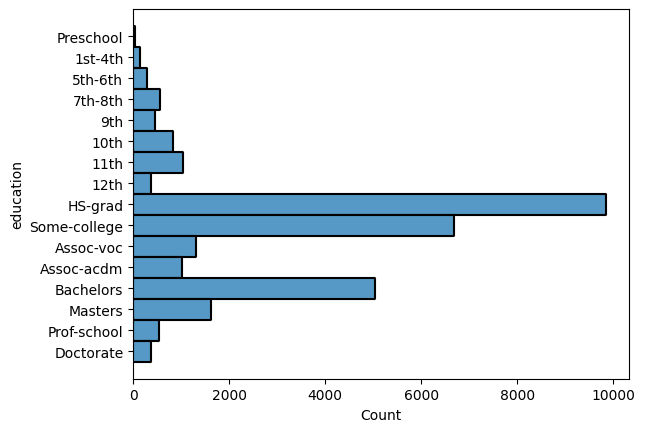

In [22]:
sns.histplot(data=adult.sort_values(by='education-num'), y='education');

### Query H2: distribution of working hours per week for people with income over 50K

In [23]:
pd.cut(adult[adult['income'] == '>50K']['hours-per-week'], bins=10).value_counts()

(30.4, 40.2]     3478
(40.2, 50.0]     2290
(59.8, 69.6]      751
(50.0, 59.8]      435
(69.6, 79.4]      151
(20.6, 30.4]      137
(10.8, 20.6]      114
(79.4, 89.2]       73
(89.2, 99.0]       41
(0.902, 10.8]      38
Name: hours-per-week, dtype: int64

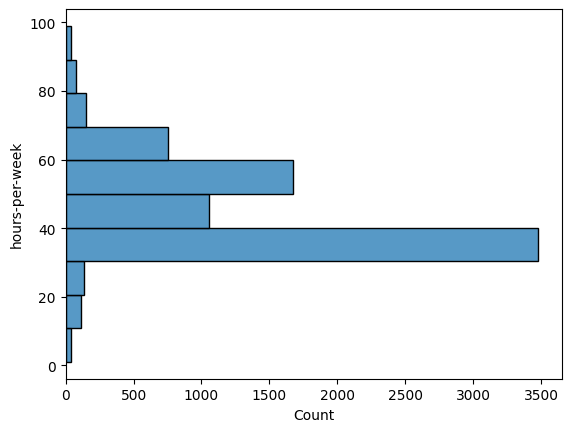

In [24]:
sns.histplot(data=adult[adult['income'] == '>50K'], y='hours-per-week', bins=10);

## Answers to the questions of the lab session

### Q1. Write a function to generate random numbers following the Laplace distribution. 

In [25]:
def my_laplace(scale, nb_noises):
    loc=0
    U = np.random.uniform(low=-1/2,high=1/2,size=nb_noises)
    X = loc- scale*np.sign(U)*np.log(1-2*np.abs(U))
    return X

Let now compare our own Laplace distribution to numpy's. 

P-value du test de Kolmogorov-Smirnov :  0.7689615674766569


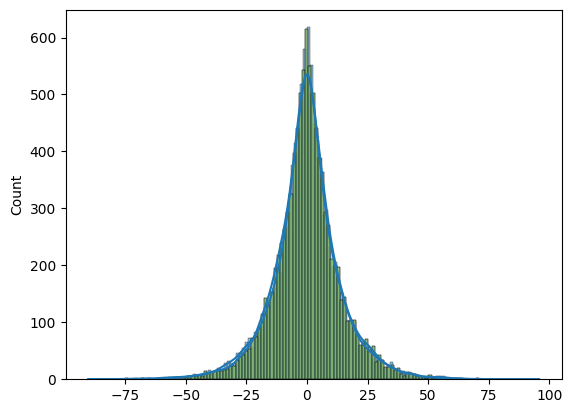

In [26]:
lap_np = np.random.laplace(loc=0, scale=10, size=10000) # Use numpy to generate laplace distribution
lap_my=my_laplace(scale=10, nb_noises=10000)

sns.histplot(lap_np, kde=True)
sns.histplot(lap_my, kde=False,color='yellow')
test_ks=ks_2samp(lap_np,lap_my)
print("P-value du test de Kolmogorov-Smirnov : ",test_ks.pvalue)

sns.histplot(lap_my, kde=True);

The default null hypothesis of the ks_2samp function is that the two sets of random variables come from the same distribution. Let our confidence level be 95%, i.e., we will reject the null hypothesis if the p-value is less than 0.05. We observe that the p-value of the KS test is higher than 0.05. As a result, we cannot reject the default null hypothesis: the random variables sampled from our own Laplace distribution and the random variables sampled from the Numpy Laplace distribution come from the same distribution with a 95% confidence level.

### Q2. Write a function that implements the Laplace mechanism. 

In [27]:
def my_laplace_mech(data, epsilon, sensitivity):
    noises=my_laplace(scale=sensitivity/epsilon, nb_noises=len(data)) 
    return data+noises

### Q3. How to perturb a count? A sum?...An average?

<h4 >A. Perturb a count</h4>

Use the Laplace mechanism with a sensitivity set to 1. 

<h4 >B. Perturb a sum</h4>

Use the Laplace mechanism with a sensitivity set to the max **absolute** value of the domain: max (|min possible|, |max possible|). 

<h4 >C. Perturb an average</h4>

The sensitivity of the average depends on the true count of the subpopulation averaged. As a result, the magnitude of the noise would leak information on the true count. This is a problem because the subpopulation averaged can be the result of filtering the full population according to personal information (e.g., average age of patients having specific characteristics). The sensitivity of the basic Laplace mechanism **must be independent from the actual data**. Thus, the average must be split in a sum query and a count query. These two queries must be executed by the Laplace mechanism with their own respective sensitivities. The division of the perturbed sum by the perturbed count can be performed by the server or by the statistician.

### Q4. Relative error.

<h4 >4.1 Query C</h4>

In [28]:
C = float(sum(adult['race'] != 'White'))

epsilons = [0.001, 0.01, 0.1, 1, 10]
sensitivity = 1
nbrepet = 100

C_all = np.empty(shape=nbrepet, dtype=float)
C_all.fill(C)

errors_C = np.empty(shape=nbrepet, dtype=float)

errors_C_avg_all = np.empty(shape=len(epsilons), dtype=float)
errors_C_std_all = np.empty(shape=len(epsilons), dtype=float)

In [29]:
i=0
for epsilon in epsilons:
    C_p = my_laplace_mech(C_all, epsilon, sensitivity)
    errors_C = abs(C_p - C)/C # We could do better ;)
    errors_C_avg = np.mean(errors_C)
    errors_C_std = np.std(errors_C)
    errors_C_avg_all[i]=errors_C_avg
    errors_C_std_all[i]=errors_C_std
    i+=1

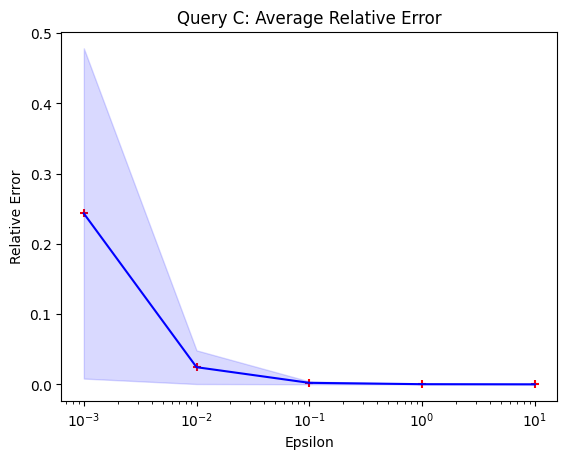

In [30]:
# Relative error and its standard deviation around.
_, ax = plt.subplots(1)
ax.set(xscale='log', yscale='linear')
ax.scatter(epsilons, errors_C_avg_all, color='red', marker='+')
ax.plot(epsilons, errors_C_avg_all, color='blue')
ax.fill_between(epsilons, np.add(errors_C_avg_all, errors_C_std_all), np.subtract(errors_C_avg_all, errors_C_std_all), color='blue', alpha=0.15)
ax.set_title("Query C: Average Relative Error")
ax.set_xlabel('Epsilon')
ax.set_ylabel('Relative Error')

plt.show()

We can draw at least the following two observations from the graph above. First, the relative error is inversely proportional to the epsilon value. This observation is expected and follows from the decreasing scale factor of the Laplace distribution. Second, the average relative error is on the order of $\epsilon/C$. This follows directly from the scale factor of the Laplace distribution and from the result $C$ of the count query. This validates our expectations as well. Additionally, a third observation could be drawn: the standard deviation of the relative error is close to the average relative error... Could you explain why? 

<h4 >4.2 Query A</h4>

*Your time to play now :)*

In [31]:
#TODO

### Q5. Unlimited number of queries.

The question aims at observing empirically the need to bound the number of queries. The code below computes and prints the difference between the average of i queries and the true query answer (i varying within 0 and the max number of queries). It can be extended in order to detect the number of queries beyond which the average stabilizes around the true value (obviously, the notion of stability should be formalized).

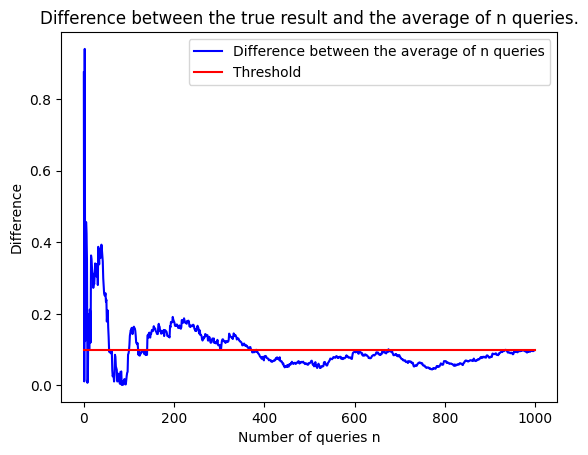

In [32]:
epsilon = 1
sensitivity = 1
nbqueries = 1000
threshold=0.1
T = np.empty(shape=nbqueries, dtype=float)
T.fill(threshold)

C = float(sum(adult['race'] != 'White'))
C_all = np.empty(shape=nbqueries, dtype=float)
C_all.fill(C)

C_pert_all=my_laplace_mech(C_all, epsilon, sensitivity)
C_avg_all = np.zeros(shape=nbqueries, dtype=float)
C_diff_all = np.zeros(shape=nbqueries, dtype=float)

for i in range(nbqueries):
    C_pert_current = np.empty(shape=i+1, dtype=float)
    C_pert_current[:i+1] = C_pert_all[:i+1] 
    C_avg_all[i]=np.mean(C_pert_current)

C_diff_all = np.abs(C_avg_all-C_all)


_, ax = plt.subplots(1)
ax.set(xscale='linear', yscale='linear')
ax.plot(range(nbqueries), C_diff_all, color='blue')
ax.plot(range(nbqueries), T, color='red')
ax.set_title("Difference between the true result and the average of n queries.")
ax.set_xlabel('Number of queries n')
ax.set_ylabel('Difference')

plt.legend(labels=["Difference between the average of n queries", "Threshold"])
plt.show()

Given $\epsilon=1$ and a threshold equal to $\theta=0.1$ we observe that the average of the results of the perturbed count queries $C$ gets both close to the true answer within the threshold and stable after a few hundred queries.  